# Team
CS20BTECH11004 Aman Panwar  \
AI20BTECH11003  Amulya Tallamraju  \
ES20BTECH11035 Pranav K Nayak  \
CS20BTECH11052 Taha Adeel Mohammed \
CS20BTECH11056 Aditya Naga Venkata Rama Vikhyath Sai Kothamasu 

# Import Libraries

In [ ]:
# Modules to be used
import torch
import random 
import numpy as np 
import pandas as pd 
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as dset
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split

# Loss function
The loss function takes in data, labels, cost parameters and flag. If flag is set to True, then it return cost dependent loss else it return cost independent loss

In [ ]:
def costsensitiveloss(h, y,y_pred, C_TP, C_TN, C_FP, C_FN,flag):
    y = y.float()

    if flag==True:
      los = (torch.dot(y * C_TP , h)+torch.dot(y * C_FN , 1-h) + torch.dot((1 - y) * C_TN, 1-h) + torch.dot((1 - y) * C_FP, h))/len(y)
    else:
      loss = nn.BCELoss()
      los=loss(y_pred,y)
    return los


# Logisitc Regression Model
The model takes in data, number of epochs, shape parameters, cost and flag as input. If flag is set to True, it performs cost sensitive logistic regression, else it performs vanilla Logistic regression.

In [ ]:
# Training, validating and fitting model
def fitModel_costsensitive(train_loader,epochs,shape_data,shape_label,costs,flag):
  # Define Logistic Regressor
  net = nn.Sequential( nn.Linear(shape_data,shape_label), nn.Sigmoid())
  # optimizer to optimize weights
  optimizer = optim.Adam(net.parameters())
  tpc,tnc,fpc=costs
  train_loss_cost,train_loss,train_acc=[],[],[]
  for epoch in range(0,epochs):
    net.train()
    losses_cost,losses,correct,total = [],[], 0, 0
    for i, (x, y,fn ) in enumerate(train_loader):
      optimizer.zero_grad()
      h = net(x).squeeze(1) # calculate current model prediction
      pred = (h-0.5>0).to(torch.int64)
      correct = correct + (pred==y).sum().item()
      
      loss_cost = costsensitiveloss(h,y,torch.squeeze(net(x)),tpc,tnc,fpc,fn,True)
      loss = costsensitiveloss(h,y,torch.squeeze(net(x)),tpc,tnc,fpc,fn,False)#cost less
      total = total + h.size(0)
      losses_cost.append(loss_cost.data.item())
      losses.append(loss.data.item())#cost less
      #if using using cost seitive model
      if flag==True:
        loss_cost.backward() # calculate gradients
      else:
        loss.backward()
      optimizer.step()
    acc, meanLosses_cost,meanLosses = 100*correct/total, np.mean(losses_cost),np.mean(losses)
    train_acc.append(acc), train_loss_cost.append(meanLosses_cost),train_loss.append(meanLosses)
    if epoch%10==0:
      print('(Epoch, Train Loss,Cost sensitive loss, Train accuracy) : ({}, {:3f}, {:3f},{:3f})'.format(epoch, train_loss[-1],train_loss_cost[-1], train_acc[-1]))
  return net,train_loss,train_acc,train_loss_cost

# Load dataset
Convert appropriate columns into tensor values

In [ ]:
# Load data
dataframe = pd.read_csv('costsensitiveregression.csv')
# converting data to Pytorch Tensors
df=dataframe.drop(["FNC"], axis = 1)
data = df.iloc[:,:-1]
data = torch.FloatTensor(data.to_numpy())
fnc=dataframe.iloc[:,-1]
fnc = torch.FloatTensor(fnc.to_numpy())
targets  = df.iloc[:,-1]
targets = torch.LongTensor(targets.to_numpy())

# Dataset description

In [ ]:
dataframe.describe()

,NotCount,YesCount,ATPM,PFD,PFG,SFD,SFG,WP,WS,AH,AN,Status,FNC
count,147636.000000,147636.000000,147636.000000,147636.000000,147636.000000,147636.000000,147636.000000,147636.000000,147636.000000,147636.000000,147636.000000,147636.000000,1.476360e+05
mean,7.722107,15.220908,0.253245,0.027062,0.050789,0.021648,0.071709,0.271927,0.493587,0.045045,0.013474,0.298586,5.334049e+02
std,7.574278,7.596921,0.366280,0.335509,0.373370,0.298285,1.135755,2.432425,0.763389,0.182274,0.100973,0.457639,8.774011e+03
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,2.000000,10.000000,0.001084,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.820820e-01
50%,4.000000,19.000000,0.033354,0.000000,0.000000,0.000000,0.000000,0.000000,0.097875,0.000000,0.000000,0.000000,1.183562e+01
75%,13.000000,21.000000,0.394372,0.000000,0.000000,0.000000,0.000000,0.061840,0.880929,0.000000,0.000000,1.000000,1.069840e+02
max,23.000000,22.000000,1.000000,79.837480,51.944780,61.556900,209.021870,399.606420,5.000000,1.000000,1.000000,1.000000,1.703186e+06


# Create Training and test datasets

In [ ]:
# Split into train and test data
dataset = dset.TensorDataset(data, targets,fnc)
train_len=int(80/100*len(dataset))
test_len=len(dataset)-train_len
split_ratio = [train_len,test_len]
(train_set, test_set) = dset.random_split(dataset, split_ratio)
train_loader = dset.DataLoader(train_set, batch_size=1024, shuffle=True, sampler=None)
test_loader = dset.DataLoader(test_set, batch_size=1024, shuffle=False, sampler=None)

# Cost Sensitive Logistic regression

In [ ]:
# Training using the data
epochs = 1000

# defining all Costs
costs= [4.0,0,4.0]


shape_data,shape_label=(df.columns.shape[0]-1,1)
net,train_loss,train_acc,train_loss_cost=fitModel_costsensitive(train_loader,epochs,shape_data,shape_label,costs,True)


(Epoch, Train Loss,Cost sensitive loss, Train accuracy) : (0, 1.684823, 5.478839,29.958174)
(Epoch, Train Loss,Cost sensitive loss, Train accuracy) : (10, 3.370238, 4.068192,29.804078)
(Epoch, Train Loss,Cost sensitive loss, Train accuracy) : (20, 4.016640, 4.021208,29.793917)
(Epoch, Train Loss,Cost sensitive loss, Train accuracy) : (30, 4.432097, 4.008923,29.793917)
(Epoch, Train Loss,Cost sensitive loss, Train accuracy) : (40, 4.784490, 4.003897,29.793917)
(Epoch, Train Loss,Cost sensitive loss, Train accuracy) : (50, 5.108505, 4.001620,29.793917)
(Epoch, Train Loss,Cost sensitive loss, Train accuracy) : (60, 5.383723, 4.000382,29.793917)
(Epoch, Train Loss,Cost sensitive loss, Train accuracy) : (70, 5.630567, 3.999397,29.793917)
(Epoch, Train Loss,Cost sensitive loss, Train accuracy) : (80, 5.248516, 3.992958,29.793917)
(Epoch, Train Loss,Cost sensitive loss, Train accuracy) : (90, 3.276803, 3.473343,54.745657)
(Epoch, Train Loss,Cost sensitive loss, Train accuracy) : (100, 4.18139

#Vanilla Logisitc regression

In [ ]:
epochs=300
net_v,train_loss_v,train_acc_v,train_loss_cost_v=fitModel_costsensitive(train_loader,epochs,shape_data,shape_label,costs,False)

(Epoch, Train Loss,Cost sensitive loss, Train accuracy) : (0, 2.018370, 8.215477,30.029295)
(Epoch, Train Loss,Cost sensitive loss, Train accuracy) : (10, 0.309270, 47.608995,86.596166)
(Epoch, Train Loss,Cost sensitive loss, Train accuracy) : (20, 0.307522, 43.052502,86.601246)
(Epoch, Train Loss,Cost sensitive loss, Train accuracy) : (30, 0.307430, 42.079549,86.630880)
(Epoch, Train Loss,Cost sensitive loss, Train accuracy) : (40, 0.307407, 41.969433,86.608866)
(Epoch, Train Loss,Cost sensitive loss, Train accuracy) : (50, 0.307485, 42.406609,86.620720)
(Epoch, Train Loss,Cost sensitive loss, Train accuracy) : (60, 0.307036, 42.310811,86.615640)
(Epoch, Train Loss,Cost sensitive loss, Train accuracy) : (70, 0.306805, 42.087397,86.594473)
(Epoch, Train Loss,Cost sensitive loss, Train accuracy) : (80, 0.306819, 42.014838,86.614793)
(Epoch, Train Loss,Cost sensitive loss, Train accuracy) : (90, 0.306773, 42.120550,86.620720)
(Epoch, Train Loss,Cost sensitive loss, Train accuracy) : (100

#Testing

In [ ]:
# Testing using the given data

net.eval()
net_v.eval()

#net.load_state_dict(torch.load('./best.pth'))
def test_stats(net):
	total, true_pos, false_pos, false_neg , correct = 0, 0, 0, 0, 0
	for i, (x, y, cfn ) in enumerate(test_loader): # evaluate on test data
		hx = net(x).squeeze(1)

		# for accuracy, find correct predictions
		pred = (hx-0.5>0).long()

		# find true positives, false positives, false negatives
		true_pos  = true_pos   + ((pred == 1)*(y==1)).sum().item() 
		false_pos = false_pos + ((pred == 1)*(y==0)).sum().item()
		false_neg = false_neg + ((pred == 0)*(y==1)).sum().item()

		correct += (pred - y == 0).sum().item()
		total = total + hx.size(0)

	# Find accuracy, precision, recall, F1 Score
	recall, precision =  true_pos, true_pos
	recall /= (true_pos+false_neg)
	precision /= (true_pos+false_pos)
	f1 = 2/((1/precision) + (1/recall))

	print('Test accuracy {:.3f}, Precision {:.3f}, Recall {:.3f}, F1 {:.3f}'.format(100.*correct/total, precision, recall, f1))
print(test_stats(net))
print(test_stats(net_v))

Test accuracy 72.927, Precision 0.528, Recall 0.951, F1 0.679
None
Test accuracy 86.664, Precision 0.809, Recall 0.730, F1 0.767
None


In [ ]:
x = list(range(0, 300))
x0 = list(range(0, 300))

# Plots

## Cost independent Loss

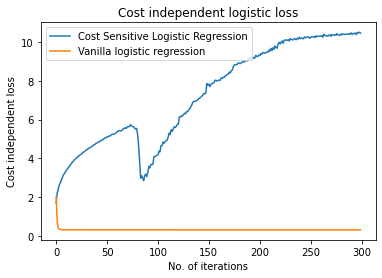

In [ ]:
plt.plot(x0, train_loss[:300], label='Cost Sensitive Logistic Regression')
plt.plot(x, train_loss_v[:300], label = 'Vanilla logistic regression')
plt.xlabel('No. of iterations')
plt.ylabel('Cost independent loss')
plt.title('Cost independent logistic loss')
plt.legend()
plt.show()

## Cost dependent Loss

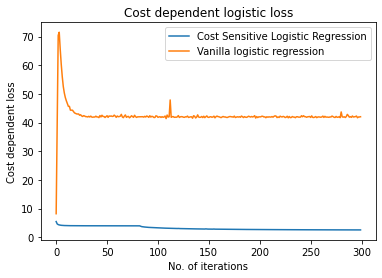

In [ ]:
plt.plot(x0, train_loss_cost[:300], label='Cost Sensitive Logistic Regression')
plt.plot(x, train_loss_cost_v[:300], label = 'Vanilla logistic regression')
plt.xlabel('No. of iterations')
plt.ylabel('Cost dependent loss')
plt.title('Cost dependent logistic loss')
plt.legend()
plt.show()

## Accuracy

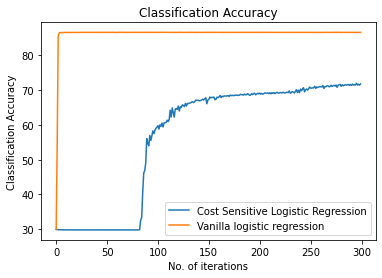

In [ ]:
plt.plot(x0, train_acc[:300], label='Cost Sensitive Logistic Regression')
plt.plot(x, train_acc_v[:300], label = 'Vanilla logistic regression')
plt.xlabel('No. of iterations')
plt.ylabel('Classification Accuracy')
plt.title('Classification Accuracy')
plt.legend()
plt.show()